ВВОДНОЕ 
====
На входе имеем файл `app.apk` для которого над узнать ключ.
Прогоняем через JADX.
На выходе имеем такую структуру файлов
```
├── resources
│   ├── AndroidManifest.xml
│   ├── META-INF
│   ├── classes.dex
│   └── res
└── sources
    ├── android
    └── example
        └── com
            └── crackme
                ├── BuildConfig.java
                ├── C0329R.java
                ├── C0333i.java
                ├── Checker.java
                └── MainActivity.java 
```
MainActivity направляет нас в Checker а он в свою очередь в C0333i.

Там нас встречает такая картина. 
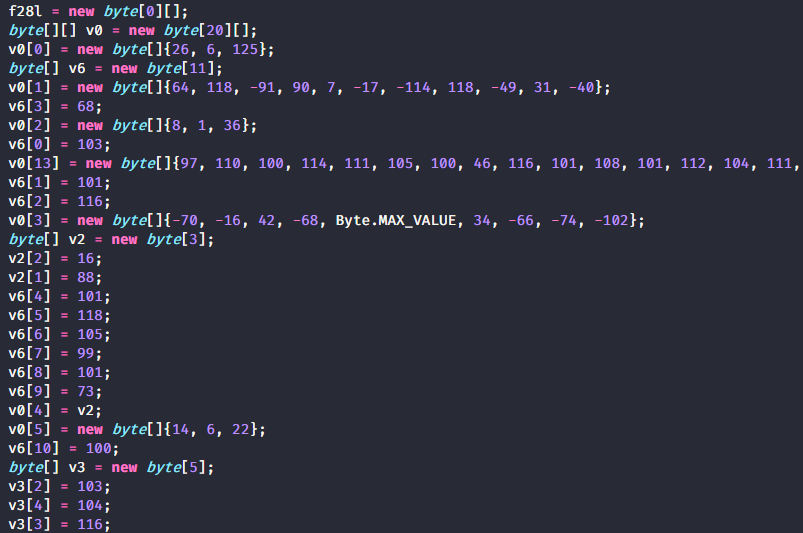
Так как следов какогото конкретного обфускатора замечено не было, было принято решение по быстрому причесать все в ручную.

Было:
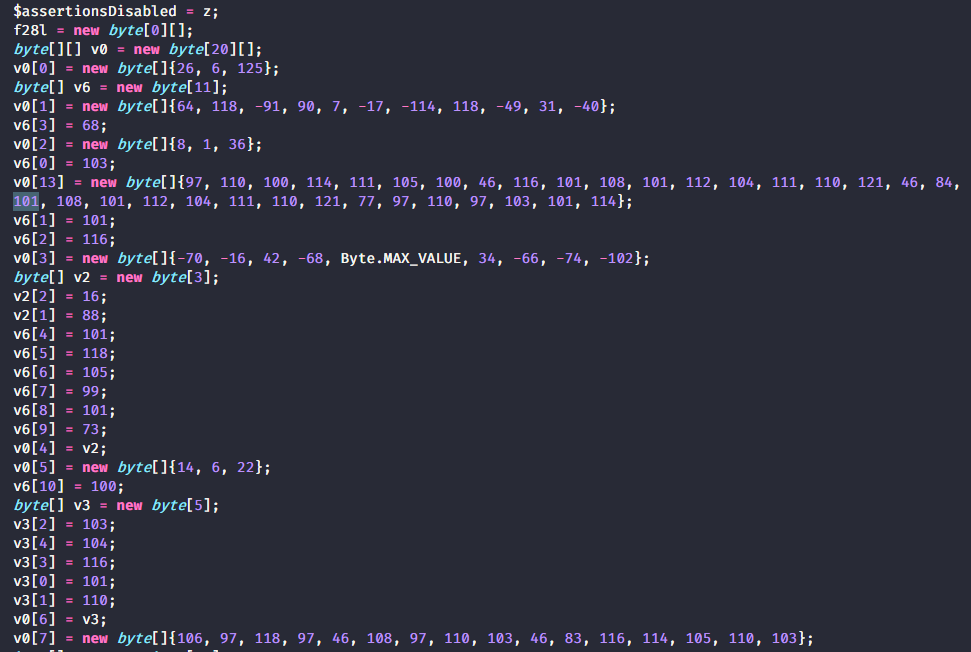
Стало:
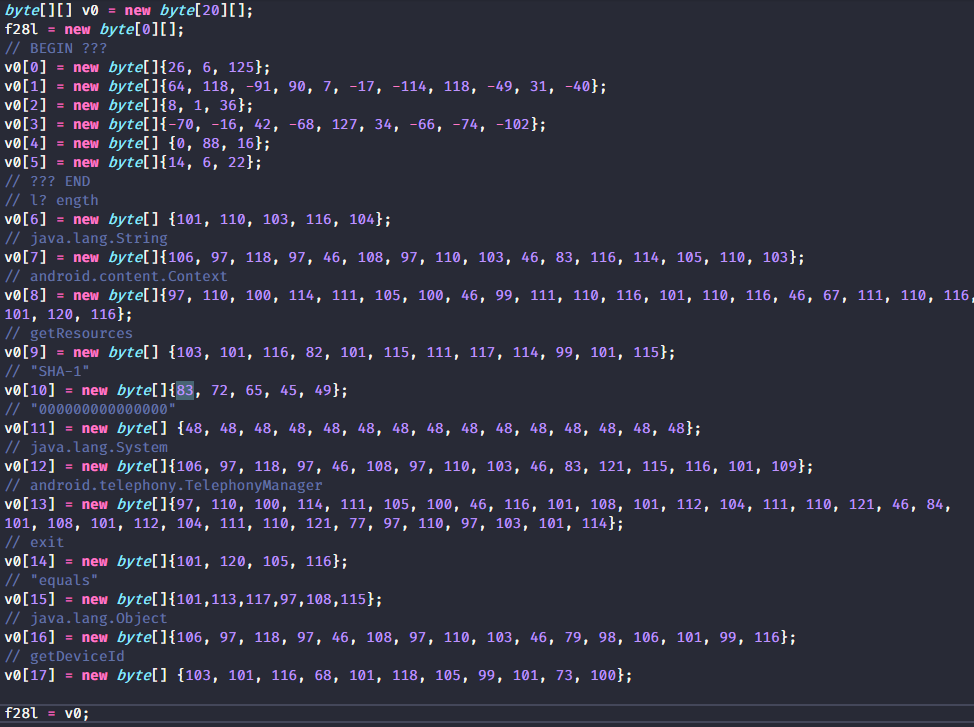
### Проверка ключа
Часть кода отвечающая за проверку ключа как есть:
```java
byte[] illll = Arrays.copyOf(MessageDigest.getInstance(new String(f28l[10])).digest(new byte[]{getbyte(123, f28l[5][0], f28l[0][2], f28l[0][1]), 2, getbyte(321, f28l[0][1], f28l[5][0], f28l[0][2])}), f28l[4][2]);
byte[] iiillliii = new byte[(f28l[1].length + f28l[3].length)];
System.arraycopy(f28l[1], 0, iiillliii, 0, f28l[1].length);
System.arraycopy(f28l[3], 0, iiillliii, f28l[1].length, f28l[3].length);
byte[] iiiiilili = new byte[(iiillliii.length + 12)];
System.arraycopy(iiillliii, 0, iiiiilili, 0, iiillliii.length);
System.arraycopy(new byte[]{122, 125, -19, 33, 69, 71, 112, -6, 36, 19, -90, 118}, 0, iiiiilili, iiillliii.length, 12);
if (((Boolean) ilil.invoke(key.replaceAll("-", "").toLowerCase(Locale.UK), new Object[]{new String(iiiilll(illll, iiiiilili))})).booleanValue()) {
    return Status.KEY_GOOD;
}
```
после "тщательного анализа програмного кода":
```java
byte[] pkey = Arrays.copyOf(
  MessageDigest //b22a4c2d516e253453b34fc49d5eda316ea1c1da
      .getInstance("SHA-1")
      .digest(
          new byte[]{
              30,//getbyte(123, (byte)14/*f28l[5][0]*/, (byte)125/*f28l[0][2]*/, (byte)6/*f28l[0][1]*/),
              2,
              120//getbyte(321, (byte)6/*f28l[0][1]*/, (byte)14/*f28l[5][0]*/, (byte)125/*f28l[0][2]*/)
          }
      ), 
  16 // new length
);
byte[] encryptedPart = new byte[(f28l[1].length + f28l[3].length)];
System.arraycopy(f28l[1], 0, encryptedPart, 0, f28l[1].length);
System.arraycopy(f28l[3], 0, encryptedPart, f28l[1].length, f28l[3].length);
byte[] encrypted = new byte[(encryptedPart.length + 12)];
System.arraycopy(encryptedPart, 0, encrypted, 0, encryptedPart.length);
System.arraycopy(new byte[]{122, 125, -19, 33, 69, 71, 112, -6, 36, 19, -90, 118}, 0, encrypted, encryptedPart.length, 12);
if (((Boolean) stringEquals.invoke(
  key.replaceAll("-", "").toLowerCase(Locale.UK)
  , new Object[]{new String(keyAes(pkey, encrypted))}
  )).booleanValue()) {
  return Status.KEY_GOOD;
}
return Status.KEY_INVALID;
```

Если введеный ключ расшифрованый ключ совпадают результат положительный

### Шифрование
Применено AES шифрование в режиме ECB 
```java
 private static byte[] keyAes(byte[] key, byte[] output) throws Exception {
        SecretKeySpec KeySpec = new SecretKeySpec(key, "AES");
        Cipher aesInst = Cipher.getInstance("AES");
        aesInst.init(Cipher.DECRYPT_MODE, KeySpec);
        return aesInst.doFinal(output);
    }
```
Шифротекст разбит на 3 части,
128 битный секретный ключ получается в результае применения хэш функциии SHA-1 на массив из 3 байт.
2 из 3 байт в данном массиве получаются через функцию getbyte.


In [1]:
def getbyte(seed, a, b, c):
    v0 = a % 25
    v1 = b % 3
    if v0 % 2 == 0: 
        return (((seed >> v0) & 255) ^ ((seed >> v1) | c))
    else:
        return (((seed >> v0) & 255) ^ ((seed >> v1) & c))

to_hash = [
    getbyte(123, 14, 125, 6),
    0x2,
    getbyte(321, 6, 14, 125),
]

Хэшируем данные из это массив и отсекаем лишнее -> полчаем секретный ключ

In [2]:
import hashlib
h = hashlib.sha1()
h.update(bytes(to_hash))
sha_digest = h.digest()[:16]

Собираем зашифрованые данные воедино

In [3]:
import struct
pt_1 = [64, 118, -91, 90, 7, -17, -114, 118, -49, 31, -40]
pt_2 = [-70, -16, 42, -68, 127, 34, -66, -74, -102]
pt_3 = [122, 125, -19, 33, 69, 71, 112, -6, 36, 19, -90, 118]
encryptred = [*pt_1, *pt_2, *pt_3]
b = struct.pack('b'*len(encryptred), *encryptred)

Расшифровываем данные полученым ключем

In [4]:
from Crypto.Cipher import AES

cipher = AES.new(sha_digest, AES.MODE_ECB, )
plaintext = cipher.decrypt(b)

print(plaintext)

b'3814606579781593\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10'


## Проверка результата
Запускаем эмулятор, устанваливаем, не работает.
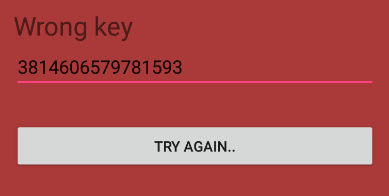

Опять внимательно смотрим декомпиилированый код и находим это
```java
Class<?> telManager2 = Class.forName("android.telephony.TelephonyManager");

if (!$assertionsDisabled && telManager2 == null) {
    throw new AssertionError();
} else if ($assertionsDisabled || javaSystem != null) {
  Method getDeviceId = telManager2.getDeclaredMethod("getDeviceId", new Class[0]);
  Method exit = javaSystem.getDeclaredMethod("exit", new Class[]{Integer.TYPE});
  // if deviceId == 000000000000000
  // -> exit
  if (((Boolean) stringEquals.invoke(getDeviceId.invoke(telManager, new Object[0]), "000000000000000")).booleanValue()) {
       exit.invoke(javaSystem, new Object[]{0});
  } 
}
```
Но, у приложения нет разрешения `android.permission.READ_PHONE_STATE` для получения `deviceId`, исправим это
Используя apktool, распаковываем:
```
> apktool d ./intro/app/app.apk
I: Using Apktool 2.4.1 on app.apk
I: Loading resource table...
I: Decoding AndroidManifest.xml with resources...
I: Loading resource table from file: C:\Users\Cami\AppData\Local\apktool\framework\1.apk
I: Regular manifest package...
I: Decoding file-resources...
I: Decoding values */* XMLs...
I: Baksmaling classes.dex...
I: Copying assets and libs...
I: Copying unknown files...
I: Copying original files...
```

Редактируем `AndroidManifest.xml` и добавляем 
```
<uses-permission android:name="android.permission.READ_PHONE_STATE" />
```
Упаковываем
```
> apktool b app
I: Using Apktool 2.4.1
I: Checking whether sources has changed...
I: Checking whether resources has changed...
I: Building resources...
W: fakeLogOpen(/dev/log_system) failed
W: fakeLogOpen(/dev/log_crash) failed
W: fakeLogOpen(/dev/log_stats) failed
W: fakeLogOpen(/dev/log_crash) failed
W: fakeLogOpen(/dev/log_stats) failed
W: fakeLogOpen(/dev/log_crash) failed
W: fakeLogOpen(/dev/log_stats) failed
W: fakeLogOpen(/dev/log_crash) failed
W: fakeLogOpen(/dev/log_stats) failed
I: Building apk file...
I: Copying unknown files/dir...
I: Built apk...
```
Подписываем
```
> jarsigner -sigalg SHA1withRSA -digestalg SHA1 -keystore my-release-key.keystore C:\home\coding\Atlantis\reverse\apktool\app\dist\app.apk alias_name
Enter Passphrase for keystore:
jar signed.

Warning:
The signer's certificate is self-signed.
```
Появилась возможность дать разрешение
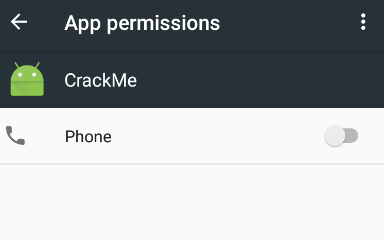

Пробуем ещё раз
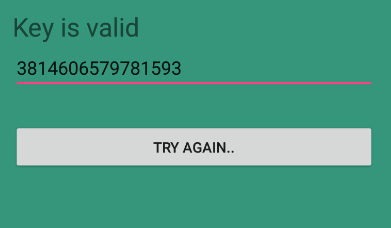
Win.